## 協調フィルタリングによる推薦

In [71]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from collections import Counter
from sklearn.datasets import make_blobs
pd.options.display.max_columns = 70
sns.set_style("whitegrid")
% matplotlib inline

### データの読み込み

In [72]:
names = ["user_id", "movie_id", "rating", "timestamp"]
u_data_df = pd.read_csv("ml-100k/u.data", delimiter='\t', header=None, names=names)

names = [
    "movie_id","movie_title","release_date","video_release_date",
    "IMDb_URL","unknown","Action","Adventure","Animation",
    "Children's","Comedy","Crime","Documentary","Drama","Fantasy",
    "Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi",
    "Thriller","War","Western"
]
u_item_df = pd.read_csv("ml-100k/u.item", delimiter='|', header=None, names=names, encoding="ISO-8859-1")

names = ["user_id", "age", "gender", "occupation", "zip_code"]
u_user_df = pd.read_csv("ml-100k/u.user", delimiter="|", header=None, names=names)

### 職業の分布

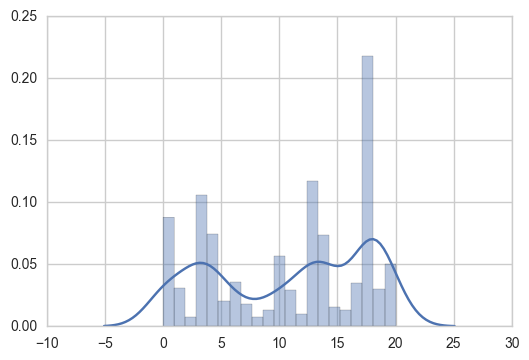

In [73]:
# sns.distplot(x=np.array(u_user_df["occupation"]))
occupation = np.array(u_user_df["occupation"])
occupation_list = np.unique(occupation)
occupation_dict = dict(zip(occupation_list, np.arange(0, len(occupation_list))))
x = [occupation_dict[i] for i in occupation]
sns.distplot(x, bins=len(occupation_list))

## 協調フィルタリングの共通アイテム数
- 相関係数を出すための共通アイテム数を決める
 - 少ないと相関係数の値が跳ね上がる
 - 例: *np.corrcoef([5,3],[4,5]) -> array([[ 1., -1.],[ 1., -1.]])*
- 適切な共通アイテム数を探すために, 統計量とプロットを行う
- 下図の結果より, 共通アイテム数の下限を, 特に多い**20**とする

レビュー回数の平均: 106.04453870625663
レビュー回数の中央値: 65.0
レビュー回数の分散: 10176.413710895373
レビュー値の平均: 3.52986
レビュー値の中央値: 4.0
レビュー値の分散: 1.2671283804


[(0, 100)]

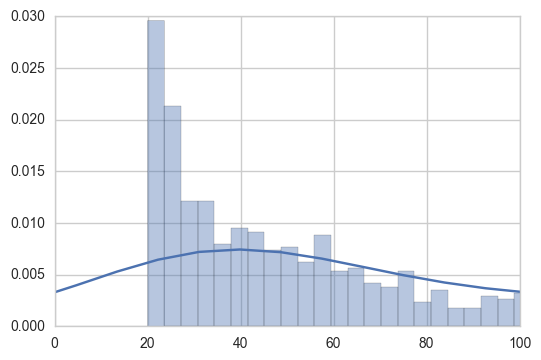

In [74]:
# 一人あたりの平均レビュー数
user_rating_times = dict(Counter(u_data_df["user_id"]))
rating_times_mean = np.mean(list(user_rating_times.values()))
rating_times_median = np.median(list(user_rating_times.values()))
rating_times_var = np.var(list(user_rating_times.values()))
print("レビュー回数の平均: {}".format(rating_times_mean))
print("レビュー回数の中央値: {}".format(rating_times_median))
print("レビュー回数の分散: {}".format(rating_times_var))

# 一人あたりのレビューの値
rating_mean = np.mean(u_data_df["rating"]) # 平均値
rating_median = np.median(u_data_df["rating"]) # 中央値
rating_var = np.var(u_data_df["rating"])  # 分散
print("レビュー値の平均: {}".format(rating_mean))
print("レビュー値の中央値: {}".format(rating_median))
print("レビュー値の分散: {}".format(rating_var ))

# レビュー回数のヒストグラム
sns.distplot(list(user_rating_times.values()), bins=200).set(xlim=(0, 100))

In [75]:
# u_dataを引数に, 行:user_id, 列:movie_id とするDataFrameを返す
def user_movie_rating_df(u_data_df, u_user_df):
    movie_id = np.unique(np.int_(u_data_df["movie_id"]))
    df = DataFrame(columns=movie_id) # 全てのmovie_idをカラムとする
    for user_id in u_user_df["user_id"]:
        # あるユーザーが観たmovie_idと, ratingを取得
        movie_rate_df = u_data_df[u_data_df["user_id"]==user_id][["movie_id", "rating"]]
        d = dict(zip(np.int_(movie_rate_df["movie_id"]), movie_rate_df["rating"]))
        # 対応するmovie_idカラムに挿入
        df = df.append(DataFrame([d]))
    df = df.fillna(0).astype(int)
    # indexをuser_idとする
    df.index = range(1, len(df)+1)
    return df

In [76]:
# 推薦対象のユーザーと, 各ユーザーのレビュー値の相関を調べる
def get_user_corrcoef(target_user_id, user_movie_rating_df):
    user_corrcoef =  {}# target_user_id対する相関係数を格納する辞書
    user1 = np.array(user_movie_rating_df.ix[target_user_id])
    # 推薦対象を除いたユーザーの中で, 相関を測る
    user_movie_rating_df=user_movie_rating_df.drop(target_user_id)
    for index, row in user_movie_rating_df.iterrows():
        user2 = np.array(user_movie_rating_df.ix[index])
        # どちらも共通の映画を観ている(評価値は気にしない)
        common_movie_id = np.where((user1!=0)&(user2!=0))[0]
        # 共通して観ている映画が20以上の時に相関を測る.
        # 共通の映画数が少ないと高確率で相関が高くなってしまう
        if len(common_movie_id) > 20:
            # 推薦対象と, あるユーザーの評価値の相関係数を調べる
            user1_rating = np.array(user1[common_movie_id])
            user2_rating = np.array(user2[common_movie_id])
            corrcoef = np.corrcoef(user1_rating, user2_rating)[0][1]
            user_corrcoef[index] = corrcoef
        else:
             user_corrcoef[index] = 0
    # DataFrameに相関係数をまとめる
    corrcoef_df = DataFrame({"user_id":list(user_corrcoef.keys()), "corrcoef":list(user_corrcoef.values())})
    corrcoef_df.sort_values(by="corrcoef", ascending=False, inplace=True)
    return corrcoef_df

In [77]:
# レコメンドするmovie_idと相関が強いuser_idを返す
def get_recommendation(corrcoef_df, user_movie_rating_df, target_user_id):
    recommendation_movie_id_set = np.array([])
    recommendation_user_id = np.array(corrcoef_df["user_id"])[0:10] # 相関の上位10個
    for id in recommendation_user_id:
        # 相関の強いユーザが高評価(rating5)していて, 自分が観ていない物をレコメンドする
        recommendation_movie_id = np.where((user_movie_rating_df.ix[target_user_id]==0)&(user_movie_rating_df.ix[id]==5))[0]+1
        recommendation_movie_id_set = np.append(recommendation_movie_id_set, recommendation_movie_id)
    # １次元にし, 重複をなくす
    recommendation_movie_id_set = np.array(recommendation_movie_id_set).flatten()
    recommendation_movie_id_set = np.int_(np.unique(recommendation_movie_id_set))
    return recommendation_user_id, recommendation_movie_id_set

In [89]:
# 精度検証 (２乗誤差平均を返す)
def check_square_error_average(test_user_movie_rating_df, target_user_id, recommand_movie_id):
    target_user_rating = np.array(test_user_movie_rating_df.ix[target_user_id][recommand_movie_id])
    # 評価には, 観ていたものだけを使う
    target_user_rating[np.isnan(target_user_rating)]=0
    target_user_rating = target_user_rating[np.nonzero(target_user_rating)]
    if len(target_user_rating) > 0:
        # get_recommendationの際に, 相関の強いユーザが高評価(rating 5)の物を取ってきたので
        # 評価値5との誤差を返す
        return np.mean(np.square(target_user_rating-5))
    else:
        return 0

In [79]:
# あるuserとuserの相関をプロットする
def corrcoef_user_plot(user_movie_rating_df, user_id1, user_id2):
    # 共通して評価している映画の
    common_movie_index = np.where((user_movie_rating_df.ix[user_id1]!=0)&(user_movie_rating_df.ix[user_id2]!=0))[0]
    x1 = np.array(user_movie_rating_df.ix[user_id1])[common_movie_index]
    x2 = np.array(user_movie_rating_df.ix[user_id2])[common_movie_index]
    print("相関: {}".format(np.corrcoef(x1,x2)[0][1]))
    x1x2_df = DataFrame({"x1":x1, "x2":x2}, index=common_movie_index)
    sns.lmplot("x1", "x2", data=x1x2_df)

## 実行

In [80]:
# 検証用データ
train_df = pd.read_csv("./ml-100k/u1.base", delimiter='\t', header=None, names=["user_id", "movie_id", "rating", "timestamp"])
test_df = pd.read_csv("./ml-100k/u1.test", delimiter='\t', header=None, names=["user_id", "movie_id", "rating", "timestamp"])

# 列がmovie_idで, 各行がユーザーのレビュー値
train_user_movie_rating_df = user_movie_rating_df(train_df, u_user_df)
test_user_movie_rating_df = user_movie_rating_df(test_df, u_user_df)

相関: 0.5765599193746256
target_user_rating: [ 2.  3.  2.  4.  5.  5.  3.  3.  3.  4.  4.  4.]
精度(２乗誤差平均): 3.1666666666666665


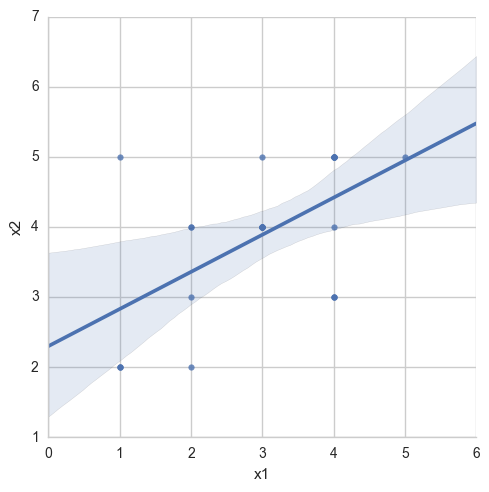

In [81]:
# 推薦
target_user_id = 100 # 推薦対象となるユーザーのuser_id
corrcoef_df  = get_user_corrcoef(target_user_id, train_user_movie_rating_df)
recommand_user_id, recommand_movie_id = get_recommendation(corrcoef_df, train_user_movie_rating_df, target_user_id)
corrcoef_user_plot(train_user_movie_rating_df, target_user_id, recommand_user_id[0]) # 相関が最上位
print("精度(２乗誤差平均): {}".format(check_square_error_average(test_user_movie_rating_df, target_user_id, recommand_movie_id)))

In [91]:
# 評価
score_set = np.array([])
train = train_df
for target_user_id in np.unique(train["user_id"]):
    corrcoef_df  = get_user_corrcoef(target_user_id, train_user_movie_rating_df)
    recommand_user_id, recommand_movie_id = get_recommendation(corrcoef_df, train_user_movie_rating_df, target_user_id)
    score = check_square_error_average(train_user_movie_rating_df, target_user_id, recommand_movie_id)
    score_set = np.append(score_set, score)
print("精度(２乗誤差平均): {}".format(np.mean(score_set)))

/Users/muraken/virl/venvML/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/muraken/virl/venvML/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


精度(２乗誤差平均): 2.0422242421181975
